### A notebook to handle figures for the (revisions of) the yoder et al. 2016 Global/Nepal ETAS paper.

The objective is a one-stop, run this script and get all your data sets and figures, shopping center. some of the scripts, however, are HUGE. global etas will take a solid 10-24 hours on 8 cores, and the production script (with expanded ranges, lower mcs, etc) might be longer. the geospatial_roc script may be similar -- a full day to run though 625 nepal_etas configurations.

accordingly, big jobs are blocked with 'if_really_do_this' booleans. to really run this, soup to nuts, those blocks will need to be removed (set to True).

In [2]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import json
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#
#import ANSStools as atp
from yodiipy import ANSStools as atp
#
import contours2kml
import globalETAS as gep
from eq_params import *
#
from nepal_figs import *
import nepal_figs
import optimizers
#
import random
import geopy
#
#colors_ =  mpl.rcParams['axes.color_cycle']
colors_ = ['b', 'g', 'r', 'c', 'm', 'y', 'k']		# make sure these are correct...
#
emc = {'lat':32.13, 'lon':-115.30, 'event_date':dtm.datetime(2010,4,4,22,40,41, tzinfo=pytz.timezone('UTC'))}
nepal_epi_lon = 84.698
nepal_epi_lat = 28.175
nepal_tms = dtm.datetime(2015, 4, 26, 7, 5, 19 ,tzinfo=pytz.timezone('UTC'))

#
# set up dict objects for different earthquakes. maybe from eq_params.py ?
param_keys = ['lat_center', 'lon_center', 'to_dt', 'mc', 'mc_auto', 'cat_len_plus']
# what exactly do we use these for?
nepal_params = {key:val for key,val in zip(param_keys, [nepal_epi_lat, nepal_epi_lon, 
                                                        nepal_tms,
                                                        3.0, 4.5, 220])}
emc_params =   {key:val for key,val in zip(param_keys, [emc['lat'], emc['lon'],
                                                      emc['event_date'] + dtm.timedelta(days=5), 2.5, 5.5, 220])}

failed while loading urllib and/or urllib. maybe python 3.x?
failed while loading urllib and/or urllib. maybe python 3.x?


### some random geopy bits:
  - easy syntax for great-circle or vincenty (more precise, iterative model) geodetic distances
  - forward and reverse geocoding
  

In [ ]:
from geopy.distance import vincenty
from geopy.distance import great_circle
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(vincenty(newport_ri, cleveland_oh).miles)
print(great_circle(newport_ri, cleveland_oh).miles)

from geopy.geocoders import Nominatim
geolocator = Nominatim()
#location = geolocator.geocode("175 5th Avenue NYC")
location = geolocator.geocode("509 S Waiola Ave, La Grange IL")
print(location.address)
print(location.point)

### ETAS and ROC figures
  - ETAS map
    - include recent (shortly before forecast date) earthquakes
  - ROC analysis
  
  Also include:
    - ETAS forecast catalog $t<t_0$
    - ETAS test catalog $t>t_0$
    - ETAS data.xyz file
    - Image(s)
    - KML
    - ROC table(s)
  
  For now, copy the make_Nepal_figs from nepal_figs.py. we'll move this to the original, or a new, module when we work out the bugs.

In [3]:
#class nepal__ROC_script(object):
#    def __init__(self, fignum=0, mcs = [4., 5., 6., 7.], n_cpu=None):
fignum=0
mcs = [4., 5., 6., 7.]
n_cpu=None

# full, one stop shopping script for nepal ROC analysis.
#
# first, get nepal ETAS objects:
#etas_fc, etas_test = etas_analyzer.nepal_etas_roc()
#
revisions_data = 'data/revisions_outputs'
if not os.path.isdir(revisions_data): os.makedirs(revisions_data)

In [ ]:
nepal_etas_fc = etas_analyzer.get_nepal_etas_fc(n_cpu=mpp.cpu_count())
#plt.savefig(os.path.join(revisions_data, 'nepal_fc_etas_contours.png'))
#
# note, nepal_etas_test does not calc. etas, but we'll want etas do to the geospatial bit.
nepal_etas_test = etas_analyzer.get_nepal_etas_test(n_cpu=mpp.cpu_count())
nepal_etas_test.make_etas()
#plt.savefig(os.path.join(revisions_data, 'nepal_test_etas_contours.png'))

#
# maybe we'll also load up one or more global forecasts as well?

In [ ]:
fg = plt.figure(1, figsize=(10,8))
plt.clf()
cm_fc = nepal_etas_fc.make_etas_contour_map(fignum=1, fig_size=(10,8))
cm_fc.scatter(*zip(*[[rw['lon'], rw['lat']] for rw in nepal_etas_fc.catalog if rw['mag']>5.]), marker='.',latlon=True )
# ... not the way to do this...
#ax=plt.gca()
#ax.set_xlim([83.,88.])
#ax.set_ylim([27., 29.5])
fg.savefig(os.path.join(revisions_data, 'nepal_fc_etas_contours.png'))

In [ ]:
fg=plt.figure(2, figsize=(10,8))
plt.clf()
cm_test = nepal_etas_test.make_etas_contour_map(fignum=2, fig_size=(10,8))
fg.savefig(os.path.join(revisions_data, 'nepal_test_etas_contours.png'))

In [ ]:
print(min(nepal_etas_test.catalog['event_date']))
print(max(nepal_etas_test.catalog['event_date']))

In [ ]:
etas_test = nepal_etas_test
test_catalog = etas_test.catalog
etas_fc = nepal_etas_fc
#
x0 = nepal_epi_lon
y0 = nepal_epi_lat
null_dist_expon = 1.5     # exponent for null model, aka aftershocks fall off like 1/r**null_dist_expon
#
mag=7.8
L_r = .5*10**(.5*mag - 1.76)
xyz = etas_fc.ETAS_array
# make a null mode with z ~ 1/r. we'll probably need a contour figure of this.
xyz_null = [[x,y,((L_r + great_circle((y,x), (y0,x0)).km)**(-null_dist_expon))] for x,y,z in xyz]
xyz_null_1 = [[x,y,((L_r + great_circle((y,x), (y0,x0)).km)**(-1.))] for x,y,z in xyz]
xyz_events = list(zip(test_catalog['lon'], test_catalog['lat'], test_catalog['mag']))
#
# now, replace all of this "get x,y and ROC" stuff with the optimizers.roc_tools equivalents.
#roc_xyz_handler = optimizers.ROC_xyz_handler(xyz, list(zip(test_catalog['lon'], test_catalog['lat'], test_catalog['mag'])),
#                                            z_event_min=None)
#
#ROC_handler = ROC_xyz_handler(xyz, xyz_events, z_event_min=None)
#
fg1=plt.figure(fignum, figsize=(10,8))
plt.clf()
ax1=plt.gca()
ax1.set_xscale('linear')

fg2=plt.figure(fignum+1, figsize=(10,8))
plt.clf()
ax2=plt.gca()
ax2.set_xscale('log')

FHs = {}        # we'll use mc as a key, FH as a val: {mc:[FH]...}
for j,mc in enumerate(mcs):
    clr = colors_[j%len(colors_)]
    print('ROC for mc={}'.format(mc))
    #
    # there's a faster way to do this...
    xyz_ev = [[x,y,z] for x,y,z in xyz_events if z>=mc]
    print("len(xyz_ev): ", len(xyz_ev))
    ROC_real = optimizers.roc_tools.ROC_xyz_handler(xyz, xyz_events, z_event_min=mc)
    ROC_null = optimizers.roc_tools.ROC_xyz_handler(xyz_null, xyz_events, z_event_min=mc)
    #ROC_null_1 = optimizers.roc_tools.ROC_xyz_handler(xyz_null_1, xyz_events, z_event_min=mc)
    #
    #events = [z for x,y,z in ROC_handler if z>=mc]
    # calc_roc(Z_fc=self.z_fc, Z_ev=self.z_events
    FH      = ROC_real.calc_roc()
    FH_null = ROC_null.calc_roc()
    #FH_null_1 = ROC_null_1.calc_roc()
    #
    ax1.plot(*zip(*FH), ls='-', color=clr, marker='', lw=2.5, label='$m_c=%.2f$' % mc)
    ax1.plot(*zip(*FH_null), ls='--', color=clr, marker='', lw=2.5, label='$1/r$: $m_c=%.2f$' % mc)
    #
    #ax2.plot(*zip(*[[f,h-f] for f,h in FH]), ls='-', color=clr, marker='', lw=2.5, label='$m_c=%.2f$' % mc)
    #ax2.plot(*zip(*[[f,h-f] for f,h in FH_null]), ls='--', color=clr, marker='', lw=2.5, label='$1/r$: $m_c=%.2f$' % mc)
    ax2.plot(*zip(*FH), ls='-', color=clr, marker='', lw=2.5, label='$m_c=%.2f$' % mc)
    ax2.plot(*zip(*FH_null), ls='--', color=clr, marker='', lw=2.5, label='$1/r$: $m_c=%.2f$' % mc)
    #
    # try a fill-between on exp=1., exp=exp_aftershcks for the null model.
    #f_null = [f for f,h in FH_null]
    #h_null_0 = [h for f,h in FH_null]
    #h_null_1 = [h for f,h in FH_null_1]
    #
    #ax1.fill_between(f_null, h_null_0, h_null_1, color=clr, alpha=.4)
    
    #
    # now we need the 1/r model, or maybe a 1/r**1.35 or so, for the reviewer.
    #
    #plt.show()    # just in case...
    #
    # now, some random catalogs:

#plt.figure()
#z_min = min([z for x,y,z in xyz])
#z_max = max([z for x,y,z in xyz])
z_len = len(xyz)
for j in range(25):
    # we probably want a better model for this, but if it works, maybe we keep it.
    R = random.Random()
    #xyz_r = [[x,y,xyz[int(z_len*R.random())][2]] for x,y,z in xyz]
    #ROC_rand = optimizers.roc_tools.ROC_xyz_handler(xyz_r, xyz_events, z_event_min=mc)
    #
    fh = optimizers.roc_tools.calc_roc([z for x,y,z in xyz], sorted([z for x,y,z in xyz], key=lambda x: R.random())[0:int(.2*z_len)])
    #
    #this_etas = etas_analyzer.Toy_etas_random(etas_in=etas_fc)
    #FH = etas_analyzer.roc_normal(this_etas, fignum=None)
    ax1.plot(*zip(*fh), marker='', ls='-', alpha=.2, color='y')
    ax2.plot(*zip(*[[f,h] for f,h in fh]), marker='', ls='-', alpha=.2, color='y')
#
#ax1.plot(range(2), range(2), ls='--', color='m', lw=3., alpha=.75, zorder=2)
ax1.plot(*zip(*[[x,x] for x in numpy.arange(0.,1.,1000)]), marker='', ls='--', color='m', lw=2.)
ax2.plot(*zip(*[[x,x] for x in numpy.arange(0.,1.,1000)]), marker='', ls='--', color='m', lw=2.)
#
ax1.set_ylim(-.05, 1.05)
ax1.set_xlim((-.05, 1.05))
ax1.grid()
ax1.legend(loc=0, numpoints=1)
ax1.set_ylabel('Hit Rate $H$', size=18)
ax1.set_xlabel('False Alarm Rate $F$', size=18)
#
ax2.set_ylim(-.05, 1.05)
ax2.set_xlim((-.05, 1.05))
ax2.grid()
ax2.legend(loc=0, numpoints=1)
ax2.set_ylabel('Reduced Hit Rate $H-F$', size=18)
ax2.set_xlabel('False Alarm Rate $F$', size=18)
#self.__dict__.update(locals())
#

#################################################
#################################################
with open(os.path.join(revisions_data, 'nepal_xyz_etas_fc.xyz'), 'w') as f:
    f.write('#x\t\ty\tz\n')
    for rw in xyz:
        f.write('{}\n'.format('\t'.join([str(x) for x in rw])))
#
with open(os.path.join(revisions_data, 'nepal_xyz_etas_fc_nul_exp_135.xyz'), 'w') as f:
    f.write('#x\t\ty\tz\n')
    for rw in xyz:
        f.write('{}\n'.format('\t'.join([str(x) for x in rw])))
#

with open(os.path.join(revisions_data, 'nepal_test_catalog.cat'), 'w') as f:
    etas_test.catalog.tofile(f, sep='\t')
with open(os.path.join(revisions_data, 'nepal_fc_catalog.cat'), 'w') as f:    
    nepal_etas_fc.catalog.tofile(f, sep='\t')

fg1.savefig(os.path.join(revisions_data, 'nepal_roc_lin.png'))
fg2.savefig(os.path.join(revisions_data, 'nepal_roc_log.png'))


#A = nepal__ROC_script()

In [ ]:
ROC_1 = optimizers.roc_tools.ROC_xyz_handler(xyz, xyz_events, z_event_min=None)
FH = ROC_1.calc_roc()

print(FH[0:5])

In [ ]:
# Now, let's write stuff to file:
plt.savefig(os.path.join(revisions_data, 'nepal_roc_figure.png'))


In [ ]:
# import global_etas_auto

# aa=global_etas_auto.auto_etas()

# #print(aa)

# #plt.figure(0,figsize=(10,8))
# #ax=plt.gca()
# aa.make_etas_contour_map(fig_size=(10,8), n_contours=25 )
# date_str = str(dtm.datetimen.now())
# plt.title('ETAS, Pacific Islands, {%s}'.format(date_str))
# #
# plt.savefig('data/pacific/pacific_20160729_{}.png'.format(date_str))
# aa.export_xyz('data/pacific/pacific_20160729_{}.xyz'.format(date_str))
# aa.export_kml('data/pacific/pacific_20160729_{}.kml'.format(date_str))

# # ... and eventually write this into globalETAS()
# with open('data/pacific/pacific_cat_20160729_{}.cat'.format(date_str)), 'w') as f:
#     aa.catalog.tofile(f, '\t')

### Global ETAS and ROC
- see nepal_figs.py.global_roc_from_optimizer()


In [3]:
figs_data_path = '/home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs'
xyz_output = os.path.join(figs_data_path, 'global_etas.xyz')
#

In [ ]:
# we need to re-code global_etas() to use a Pool() instead of manual process handling. in the mean time, just give it
# more processes than it has processors (then, the small jobs will finish up early, and the multiple-thread overhead
# should be relatively small). the idea is to have all processors running flat out, all the time... and not run out
# of memory.
do_global = False
if do_global:
    n_cpu = mpp.cpu_count()*3
    #
    # note: the default behavior for this is to give a forcast date of now-fc_len, and so a forecast validation up to today.
    #
    glob_etas_roc =  global_etas_and_roc(fc_len=120, fout_xyz=xyz_output, fignum=0, m_cs=[4.0, 5.0, 6.0, 6.5], n_cpu=n_cpu)
    #

    with open(os.path.join(figs_data_path, 'global_roc_FH.json'), 'w') as f:
        json.dump(glob_etas_roc['roc'],f)

#global ETAS

#lats=[-89.0, 89.0]	lons=[-180.0, 180.0]	mc=3.0	d_lon=0.1	d_lat=0.1	etas_range_factor=15.0	etas_range_padding=0.5	etas_fit_factor=1.5	t_now=2016-04-12 12:52:58.803348+00:00	cat_len=3650.0

begin roc_glob...
get cataog:  [-180.0, 179.90000000000001] [-89.0, 88.900000000000006] 4.0 2016-04-12 12:52:59+00:00 2016-08-10 12:52:59+00:00
data handle fetched...
 no file.
catlen:  4151
finished with roc_glob...


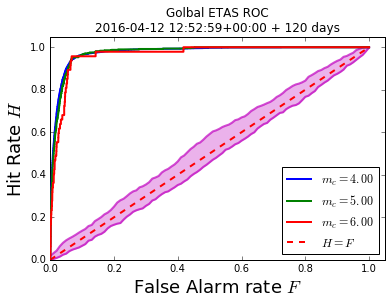

In [4]:
#roc_glob = global_roc_from_optimizer(fc_xyz=etas.ETAS_array, fignum=fignum+1, mcs=6.0,
#fc_len=fc_len, ls=roc_ls, marker=roc_marker, lw=roc_lw)
# print header data from global eatas output:
# (and if we need to, we can extract the prams from here.)
with open(xyz_output,'r') as f:
    for rw in f:
        if rw[0]=='#':
            print(rw)
        else:
            #
            # and assume 1) it's a long file, 2) all the comments are at the front.
            break
        #
    #
#
   

# do roc starting just after end of etas (be careful trying to make this more/less fair;
#see the global_roc_from_optimizer code.)
#
print('begin roc_glob...')
# should be returning like [[mc, [FH]], [mc, [FH]], ]   # where [FH] implies an array return like [[f,h], [f,h], ... ]
roc_glob = global_roc_from_optimizer(fc_xyz=xyz_output, fignum=0,
                                     etas_end_date=dtm.datetime(2016,4,12, 12,52,59, tzinfo=pytz.timezone('UTC')),
                                     mcs=[4.,5., 6.0], fc_len=120, ls='-', marker='', lw=2)
print('finished with roc_glob...')

In [ ]:
## Diagnostic
# print(len(roc_glob))

# sums = optimizers.roc_tools.integrate_fh([rw[-1][0:1000000] for rw in roc_glob], n_cpu=2)
# print('sums: ', sums)

# print(optimizers.roc_tools.integrate_fh(roc_glob[0][-1]))
# print(optimizers.roc_tools.integrate_fh(roc_glob[2][-1]))

In [ ]:
# TODO: write this into roc_tools.py.
# make a single call that nests the spp and mpp versions; maybe also add some code to discriminate
# leading meta-data in a row, so we can pass [[x1,x2,..., FH], ...]
# ### see optimizers.roc_tools.py for working integrate_fh(). this version will take FH, [FH, FH, FH]
# and handles mpp as well... but be careful with it, since it can be memory intensive.

# def integrate_fh(FH, skill=True):
#     f_factor=skill%2    # integrate skill score (h-f) or h score
#     #
#     # do simple block integration; err on the side of a higher score.
#     return numpy.sum([(h-f_factor*f)*(f-FH[j][0]) for j, (f,h) in enumerate(FH[1:])])

# n_cpu = None
# n_cpu = 3
# n_cpu = (n_cpu or mpp.cpu_count())

# # note: i think these global ROC bits are about 2GB each...

# if n_cpu>1:
#     P = mpp.Pool(mpp.cpu_count())
#     res=[]
#     outputs = []
#     for mc, fh in roc_glob:
#         #print('score:', mc, integrate_fh(fh))
#         res += [[mc, P.apply_async(integrate_fh, args=(fh,True))]]
#     P.close()
#     P.join()
#     for mc, r in res:
#         outputs += [[mc, r.get()]]
#         print('mc: {}::{}'.format(mc, outputs[-1][1]))
# else:
#     for mc,fh in roc_glob:
#         print('score: {} :: {}'.format(mc, integrate_fh(fh)))
#     #

outputs = optimizers.roc_tools.integrate_fh([rw[-1] for rw in roc_glob], n_cpu=1)

In [ ]:
for mc, score in outputs:
    print('{}: {}'.format(mc, score/.5))

In [ ]:


plt.figure(0, figsize=(14,10))
print('working... (this might take a while)...')
# nepal_figs.
CC = draw_global_etas_contours(xyz=xyz_output, fignum=0)

print('finishd.')

In [ ]:
print(xyz_output)

In [ ]:
roc_glob = global_roc_from_optimizer(fc_xyz=xyz_output, fignum=0, mcs=[4.,5.,6.], fc_len=120, ls='-', 
                                                marker='', lw=2, etas_end_date=dtm.datetime(2016,4,12,13,
                                                                                            tzinfo=nepal_figs.pytz.timezone('UTC')))

# for global, this will be... HUGE, >600MB. the binary .pkl object (see below) is 500 MB.
# for publication, we can share an interpolated copy.
#with open(os.path.join(figs_data_path, 'global_roc_FH.json'), 'w') as f:
#    json.dump(roc_glob, f)

In [ ]:
import pickle

with open(os.path.join(figs_data_path, 'global_roc_FH.pkl'), 'wb') as f:
    pickle.dump(roc_glob,f)

### ROC geospatial ranges

In [5]:
# first, get all the ROC geospatials...
# there is, i think, another version of this script that should be faster (same module).
# (this version takes about a day at 8 x 1.77GHz)

do_roc_gs_calcs = False

f_path  = '/home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/gs_roc_q_v_q'
f_pkl   = os.path.join(f_path, 'etas_roc_geospatial_FHs.pkl')
f_json  = os.path.join(f_path, 'etas_roc_geospatial_FHs.json')
f_csv   = os.path.join(f_path, 'etas_roc_geospatial_FHs.csv')

if do_roc_gs_calcs:
    aa=eap.etas_roc_geospatial_raw(q_t_min=1.1, q_t_max=3.5, q_fc_min=1.1, q_fc_max=3.5,
                                   dq_fc=.1, dq_t=.1, fignum=0, fout=f_csv)
    os.makedirs(f_path)
    plt.figure(0)
    plt.plot(range(2), range(2), ls='--', lw=2., color='r')

    for j in list(range(0,8))+[42]:
        plt.figure(j)
        plt.savefig(os.path.join(f_path, 'etas_roc_geospatial_raw_output_fig_{}.png'.format(j)))

    # dump/save the data
    with open(f_pkl, 'wb') as fout:
        pickle.dump(aa,fout)

    # turns out these data sets aren't that big:
    with open(f_json, 'w') as fout:
        json.dump(aa,fout)

    

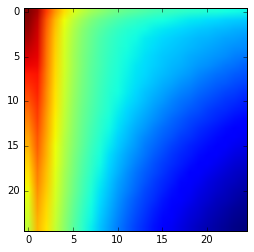

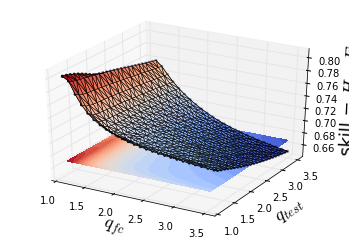

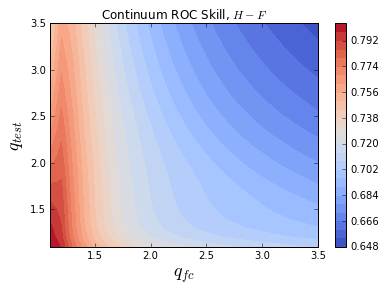

In [7]:
#f_path = '/home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/gs_roc_q_v_q'
roc_gs_datas = json.load(open(f_json))

#print(roc_gs_datas[0:3])
# eventually, start using this script (again); adapt it to accept either a tabular csv or a .json.
# q_q_skill_figs(data='data/roc_geospatial_nepal_q11_24_11_24.csv')

Xs=sorted(list(set([x for x,y,f,h in roc_gs_datas])))
Ys=sorted(list(set([y for x,y,f,h in roc_gs_datas])))
Zs=numpy.array(list([h-f for x,y,f,h in roc_gs_datas]))
#
Zs.shape=(len(Ys), len(Xs))
#
plt.imshow(Zs.transpose())



cc=nepal_figs.q_q_skill_figs(os.path.join(f_path, f_json), fignum=4)
